## Создание сетки и триангуляция области

In [165]:
from itertools import product, chain
from scipy.spatial import Delaunay
import numpy as np
par=3
boundaries=np.array([[0.01, 0.01], [0.02, 0.01], [0.02, 0.02], [0.01, 0.02]])
x_list, y_list=np.linspace(0.01, 0.02, par), np.linspace(0.01, 0.02, par)
points = np.array(list(product(x_list,y_list)))
tri = Delaunay(points)
delaunay_conditions = list(chain([[idx, 1] for idx, x in enumerate(points) if x[1]==boundaries[0,1]],
                                [[idx, 0] for idx, x in enumerate(points) if x[0]==boundaries[1,0]]))
neumann_conditions=[[2, 0, -2e+7]]
#sorted(delaunay_conditions, key=lambda x: x[0])

## Построение сетки

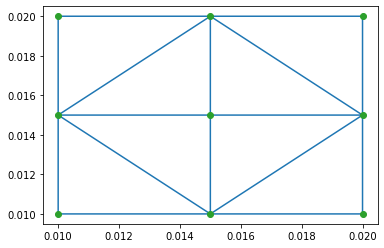

In [156]:
import matplotlib.pyplot as plt
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

## Создание файла с данными

In [117]:
#Коэффициенты для задачи
dimTask=2
enableSchwarz=0
coefOverlay=0.3
amntSubdomains=2
E=70e+9
nyu=0.34
coef_u=1000
coef_sigma=1e-3

In [4]:
with open("test1.dat","w") as f:
    f.write(str(dimTask)+'\n')
    f.write("{:d} {:g} {:d}\n".format(enableSchwarz, coefOverlay, amntSubdomains))
    f.write("{:g} {:g}\n".format(E, nyu))
    f.write("{:g} {:g}\n".format(coef_u, coef_sigma))
    f.write("{:d}\n".format(len(points)))
    for point in points:
        f.write("{:g} {:g}\n".format(point[0], point[1]))
    f.write("{:d}\n".format(len(tri.simplices)))
    for element in tri.simplices:
        f.write("{:g} {:g} {:g}\n".format(element[0], element[1], element[2]))
        

In [5]:
#with open("test1.dat") as f:
#    dimTask=int(f.readline())
#    enableSchwarz, coefOverlay, amntSubdomains = list(map())

In [166]:
import numpy as np
import scipy
K_global=np.zeros((len(points)*2,len(points)*2))
F=np.zeros((len(points)*2,1))
par_lambda=nyu*E/(1+nyu)/(1-2*nyu)
par_myu=E/2/(1+nyu)
#D=np.array([[1, nyu, 0], [nyu, 1, 0], [0, 0, (1-nyu)/2]])*E/(1-nyu*nyu)
D=np.array([[1, nyu/(1-nyu), 0], [nyu/(1-nyu), 1, 0], [0, 0, (1-2*nyu)/2/(1-nyu)]])*E*(1-nyu)/(1-2*nyu)/(1+nyu)
#D=np.array([[par_lambda+2*par_myu, par_lambda, 0], [par_lambda, par_lambda+2*par_myu, 0], [0, 0, 2*par_myu]])
for element in tri.simplices:
    B=np.zeros((3, 6))
    x_points=np.array([points[element[0], 0], points[element[1], 0], points[element[2], 0]])
    y_points=np.array([points[element[0], 1], points[element[1], 1], points[element[2], 1]])
    a=np.array([x_points[1] * y_points[2] - x_points[2] * y_points[1], 
               x_points[2] * y_points[0] - x_points[0] * y_points[2],
               x_points[0] * y_points[1] - x_points[1] * y_points[0]])
    b=np.array([y_points[1]-y_points[2], y_points[2]-y_points[0], y_points[0]-y_points[1]])
    c=np.array([x_points[2]-x_points[1], x_points[0]-x_points[2], x_points[1]-x_points[0]])
    A=0.5*np.linalg.det(np.array([[1, 1, 1], [x_points[0], x_points[1], x_points[2]], 
                                  [y_points[0], y_points[1], y_points[2]]]).transpose())
    for i in range(len(element)):
        B[:, i*dimTask:i*dimTask + 2] += np.array([[b[i], 0], [0, c[i]], [c[i]/2, b[i]/2]])/2/A
    K=np.dot(np.dot(B.transpose(), D), B) * A
    for i in range(3):
        for j in range(3):
            K_global[element[i]*dimTask:element[i]*dimTask+2, element[j]*dimTask:element[j]*dimTask+2]+=K[i*dimTask:i*dimTask+2,j*dimTask:j*dimTask+2]
for point in delaunay_conditions:
    K_global[point[0]*dimTask+point[1], :] = 0
    K_global[:, point[0]*dimTask+point[1]] = 0
    K_global[point[0]*dimTask+point[1], point[0]*dimTask+point[1]] = 1
ax=[idx for idx, i in enumerate(points) if boundaries[2, 1]==i[1]]
for point in neumann_conditions:
    for i in ax:
        F[i*dimTask]+=point[1] * 0.01 / (par-1) / 2
        F[i*dimTask+1]+=point[2] * 0.01 / (par-1) / 2
    for i in ax[1:-1]:
        F[i*dimTask]+=point[1] * 0.01 / (par-1) / 2
        F[i*dimTask+1]+=point[2] * 0.01 / (par-1) / 2
L=[id for id, element in enumerate(tri.simplices) if len([x for x in element if x in [idx for idx, i in enumerate(points) if boundaries[2, 1]==i[1]]])==2]
u=np.linalg.solve(K_global, F).reshape((points.shape[0],2))*coef_u
#print(u)

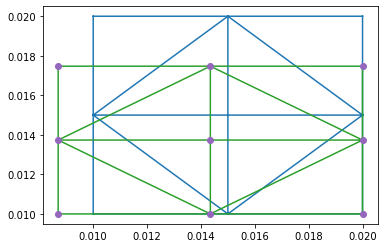

In [167]:
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
plt.triplot(u[:, 0] + points[:, 0], u[:,1] + points[:, 1], tri.simplices.copy())
plt.plot(points[:,0] + u[:, 0], points[:,1] + u[:, 1], 'o')
plt.show()

In [168]:
Eps=[]
for element in tri.simplices:
    B=np.zeros((3, 6))
    x_points=np.array([points[element[0], 0], points[element[1], 0], points[element[2], 0]])
    y_points=np.array([points[element[0], 1], points[element[1], 1], points[element[2], 1]])
    a=np.array([x_points[1] * y_points[2] - x_points[2] * y_points[1], 
               x_points[2] * y_points[0] - x_points[0] * y_points[2],
               x_points[0] * y_points[1] - x_points[1] * y_points[0]])
    b=np.array([y_points[1]-y_points[2], y_points[2]-y_points[0], y_points[0]-y_points[1]])
    c=np.array([x_points[2]-x_points[1], x_points[0]-x_points[2], x_points[1]-x_points[0]])
    A=0.5*np.linalg.det(np.array([[1, 1, 1], [x_points[0], x_points[1], x_points[2]], 
                                  [y_points[0], y_points[1], y_points[2]]]).transpose())
    for i in range(len(element)):
        B[:, i*dimTask:i*dimTask + 2] = np.array([[b[i], 0], [0, c[i]], [c[i]/2, b[i]/2]])/2/A
    Eps.append(np.dot(B, np.ravel(np.array([u[element[0]], u[element[1]], u[element[2]]])).transpose()))
Eps=np.array(Eps)
Sigma=np.dot(D, Eps.transpose())
print(Sigma.transpose()*coef_sigma)

[[-7.62939453e-09 -2.00000000e+07 -3.26231579e-09]
 [-9.53674316e-09 -2.00000000e+07 -2.89983626e-09]
 [-9.53674316e-09 -2.00000000e+07 -2.17487719e-09]
 [ 5.72204590e-09 -2.00000000e+07 -4.34975439e-09]
 [ 1.90734863e-09 -2.00000000e+07  1.81239766e-09]
 [ 0.00000000e+00 -2.00000000e+07  0.00000000e+00]
 [-3.81469727e-09 -2.00000000e+07  1.81239766e-09]
 [ 9.53674316e-09 -2.00000000e+07  2.89983626e-09]]
